In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pylab
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform

from xgboost import XGBRegressor


import joblib

Remember; our target is 'loan_status'

In [2]:
import csv
with open('data/accepted_2007_to_2018Q4.csv', 'r', encoding='utf-8', errors='ignore') as f:
    total_rows = sum(1 for _ in f) - 1  

frac = 100_000 / total_rows

target = 100_000
parts = []
for chunk in pd.read_csv('data\\accepted_2007_to_2018Q4.csv', chunksize=100_000, low_memory=False):
    parts.append(chunk.sample(frac=target/ (2e6), random_state=42))  # adjust frac as needed
df = pd.concat(parts, ignore_index=True)

In [3]:
df = pd.read_csv('data\\accepted_2007_to_2018Q4.csv', low_memory=False).sample(n=100_000, random_state=42)

In [4]:
df.shape

(100000, 151)

Immediately removing rows that are missing a very significant amount of values (probably outdated at the time of data fetching, and didn't include newer features) so that I do not waste time redundantly filling NaNs for these rows.

<br>

In [5]:
print(df.shape)
list(df.columns)

(100000, 151)


['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 392949 to 347653
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 116.0+ MB


<br>

 Dropping empty cols and cols with mostly empty values that are unnecessary and provide mostly no value to the model

In [7]:
df.drop(df.columns[df.isna().all()],axis=1, inplace=True)

In [8]:
keep_cols = ['mths_since_last_major_derog', 'mths_since_last_record', ]
drop_cols = [c for c in df.columns[df.isna().mean() > 0.7] if c not in keep_cols]
df.drop(columns = drop_cols, axis=1, inplace=True)

In [9]:
df.shape

(100000, 112)

In [10]:
df.dtypes

id                             object
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
                               ...   
total_bc_limit                float64
total_il_high_credit_limit    float64
hardship_flag                  object
disbursement_method            object
debt_settlement_flag           object
Length: 112, dtype: object

In [11]:
object_types = df.select_dtypes('object').apply(lambda col: col.dropna().map(type).value_counts().index[0])
print(object_types)

id                      <class 'str'>
term                    <class 'str'>
grade                   <class 'str'>
sub_grade               <class 'str'>
emp_title               <class 'str'>
emp_length              <class 'str'>
home_ownership          <class 'str'>
verification_status     <class 'str'>
issue_d                 <class 'str'>
loan_status             <class 'str'>
pymnt_plan              <class 'str'>
url                     <class 'str'>
purpose                 <class 'str'>
title                   <class 'str'>
zip_code                <class 'str'>
addr_state              <class 'str'>
earliest_cr_line        <class 'str'>
initial_list_status     <class 'str'>
last_pymnt_d            <class 'str'>
next_pymnt_d            <class 'str'>
last_credit_pull_d      <class 'str'>
application_type        <class 'str'>
hardship_flag           <class 'str'>
disbursement_method     <class 'str'>
debt_settlement_flag    <class 'str'>
dtype: object


Down below, we want to find out which columns with dtype = object are dates

In [12]:
import warnings
warnings.filterwarnings("ignore", message="Could not infer format")

possible_dates = []

for col in df.select_dtypes('object').columns:
    parsed = pd.to_datetime(df[col], errors='coerce')
    ratio = parsed.notna().mean()
    print(f"{col}: {ratio:.2f}")
    if ratio > 0.8:
        possible_dates.append(col)

print("\nLikely date columns:", possible_dates)

id: 0.00
term: 0.00
grade: 0.00
sub_grade: 0.00
emp_title: 0.00
emp_length: 0.00
home_ownership: 0.00
verification_status: 0.00
issue_d: 1.00
loan_status: 0.00
pymnt_plan: 0.00
url: 0.00
purpose: 0.00
title: 0.00
zip_code: 0.00
addr_state: 0.00
earliest_cr_line: 1.00
initial_list_status: 0.00
last_pymnt_d: 1.00
next_pymnt_d: 0.41
last_credit_pull_d: 1.00
application_type: 0.00
hardship_flag: 0.00
disbursement_method: 0.00
debt_settlement_flag: 0.00

Likely date columns: ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']


Therefore, 'issue_d' (date the loan was funded), 'earliest_cr_line' (date the borrower's earliest credit line was opened).

However, the following 3 cols need to be dropped since they contain post loan-issue data, which would cause data leakage, since it is giving the model information from the future. These are; 
- 'last_pymnt_d' (Last month the borrower made a payment)
- 'next_pymnt_d' (Next scheduled payment date)
- 'last_credit_pull_d';  (Last date LendingClub pulled the borrower’s credit (for ongoing monitoring))

In [13]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month
df.drop(columns='issue_d', inplace=True)



df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')

df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year
df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month
df.drop(columns='earliest_cr_line', inplace=True)

Here, we turned 'issue_d' & 'earliest_cr_line' into two columns, one for the year and another for the month, thereby allowing the model to learn yearly and seasonal patterns separatly and directly.

In [14]:
#Removing cols to avoid data leakage
df.drop(columns=['last_pymnt_d', 'last_credit_pull_d', 'next_pymnt_d'], axis=1, inplace=True)

In [15]:
df.select_dtypes('bool').columns

Index([], dtype='object')

In [16]:
bool_candidates = [
    c for c in df.columns
    if df[c].dropna().nunique() == 2
]
print(bool_candidates)

['term', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


In [17]:
df['term'] = df['term'].fillna(df['term'].mode()[0])

df['term'] = df['term'].str.extract(r'(\d+)').astype('int8')

In [18]:
df.drop(columns='pymnt_plan', inplace=True)

'pymnt_plan' (Indicates if a payment plan has been put in place for the loan), this introduces data leakage, hence dropping it.

In [19]:
df['initial_list_status'].value_counts(dropna=False)

initial_list_status
w      67767
f      32229
NaN        4
Name: count, dtype: int64

In [20]:
df['initial_list_status'] = df['initial_list_status'].map({'w': 1, 'f': 0}).fillna(1).astype('int8')

In [21]:
cols = ['application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']
for c in cols:
    print(df[c].value_counts(dropna=False))

application_type
Individual    94614
Joint App      5382
NaN               4
Name: count, dtype: int64
hardship_flag
N      99950
Y         46
NaN        4
Name: count, dtype: int64
disbursement_method
Cash         96477
DirectPay     3519
NaN              4
Name: count, dtype: int64
debt_settlement_flag
N      98411
Y       1585
NaN        4
Name: count, dtype: int64


In [22]:
df['application_type'] = df['application_type'].map({'Individual': 0, 'Joint App':1}).fillna(0).astype('int8')

In [23]:
df.drop(columns='hardship_flag', inplace=True)

This introduces data leakage (flag appears only after the loan has been issued and the payment history begins)

In [24]:
df['disbursement_method'] = df['disbursement_method'].map({'Cash': 0, 'DirectPay': 1}).fillna(0).astype('int8')

In [25]:
df.drop(columns='debt_settlement_flag', inplace=True)

Another column that would cause data leakage

In [26]:
bool_candidates = [
    c for c in df.columns
    if df[c].dropna().nunique() == 3
]

for c in bool_candidates:
    print(df[c].value_counts(dropna=False)) 


verification_status
Source Verified    39471
Not Verified       32767
Verified           27758
NaN                    4
Name: count, dtype: int64
num_tl_120dpd_2m
0.0    93204
NaN     6729
1.0       65
2.0        2
Name: count, dtype: int64


In [27]:
df['verification_status'] = df['verification_status'].replace({'Source Verified':'Verified'})
df['verification_status'] = df['verification_status'].map({'Verified':1, 'Not Verified':0}).fillna(0).astype('int8')

In [28]:
df['num_tl_120dpd_2m_missing'] = df['num_tl_120dpd_2m'].isna().astype('int8')
df['num_tl_120dpd_2m'] = df['num_tl_120dpd_2m'].fillna(0).astype('int8')

In [29]:
df['num_tl_30dpd_missing'] = df['num_tl_30dpd'].isna().astype('int8')
df['num_tl_30dpd'] = df['num_tl_30dpd'].fillna(0).astype('int8')

In [30]:
bool_candidates = [
    c for c in df.columns
    if 3 < df[c].dropna().nunique() < 10
]

for c in bool_candidates:
    print(df[c].value_counts(dropna=False)) 

grade
B      29210
C      28922
A      18930
D      14443
E       6074
F       1856
G        561
NaN        4
Name: count, dtype: int64
home_ownership
MORTGAGE    48797
RENT        39881
OWN         11260
ANY            45
OTHER           8
NONE            5
NaN             4
Name: count, dtype: int64
loan_status
Fully Paid                                             47460
Current                                                38887
Charged Off                                            12034
Late (31-120 days)                                       969
In Grace Period                                          368
Late (16-30 days)                                        187
Does not meet the credit policy. Status:Fully Paid        60
Does not meet the credit policy. Status:Charged Off       31
NaN                                                        4
Name: count, dtype: int64
collections_12_mths_ex_med
0.0    98373
1.0     1511
2.0       97
NaN        6
3.0        5
4.0        5
5.0  

In [31]:
grade_map = {'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1}
df['grade'] = df['grade'].map(grade_map)
df = df.dropna(subset=['grade', 'inq_last_6mths', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths','pub_rec_bankruptcies'])

In [32]:
df['home_ownership'] = df['home_ownership'].replace(['NONE','ANY','OTHER'], 'OTHER')
dummies = pd.get_dummies(df['home_ownership'], drop_first=True)
df = pd.concat([df, dummies], axis=1)
df.drop(columns='home_ownership', inplace=True) 

In [33]:
df['inq_last_6mths'] = df['inq_last_6mths'].clip(upper=6)
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].clip(upper=2)
df['acc_now_delinq'] = df['acc_now_delinq'].clip(upper=1)
df['chargeoff_within_12_mths'] = df['chargeoff_within_12_mths'].clip(upper=2)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].clip(upper=3)


Cleaning target y (Fully Paid (Does not default): 0, Charged Off (Default): 1). Also merging redundant categories as well as dropping rows that contain 'loan_status' as Late or in grace period (since these are not helpful for the model)

In [34]:
df['loan_status'] = df['loan_status'].replace({
    'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
    'Does not meet the credit policy. Status:Charged Off': 'Charged Off'
})

# Keeping only finalized loans
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].reset_index(drop=True)

df['loan_status'] = df['loan_status'].map({'Fully Paid':0, 'Charged Off': 1})


In [35]:
nan_mask = df.isna().sum(axis=1)
df = df[nan_mask < 40].reset_index(drop=True)

In [36]:
from IPython.display import HTML
HTML(df.head(15).to_html())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,annual_inc,verification_status,loan_status,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,issue_year,issue_month,earliest_cr_line_year,earliest_cr_line_month,num_tl_120dpd_2m_missing,num_tl_30dpd_missing,OTHER,OWN,RENT
0,16411620,9600.0,9600.0,9600.0,36,12.99,323.42,5.0,C1,NaN,NaN,21900.0,1,0,https://lendingclub.com/browse/loanDetail.action?loan_id=16411620,debt_consolidation,Debt consolidation,331xx,FL,10.03,0.0,685.0,689.0,1.0,NaN,118.0,13.0,1.0,4509.0,38.9,20.0,1,0.0,0.0,11643.969042,11643.97,9600.0,2043.97,0.0,0.00,0.0000,0.85,544.0,540.0,0.0,NaN,1.0,0,0.0,0.0,4509.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11600.0,NaN,NaN,NaN,6.0,347.0,871.0,63.7,0.0,0.0,97.0,157.0,1.0,1.0,0.0,26.0,1.0,NaN,0.0,2.0,5.0,2.0,5.0,2.0,13.0,18.0,5.0,13.0,0,0,0.0,2.0,100.0,50.0,1.0,0.0,11600.0,4509.0,2400.0,0.0,0,2014.0,5.0,2001.0,4.0,0,0,False,False,True
1,45122316,4000.0,4000.0,4000.0,36,6.68,122.93,7.0,A3,System Analyst,4 years,83000.0,0,0,https://lendingclub.com/browse/loanDetail.action?loan_id=45122316,major_purchase,Major purchase,333xx,FL,19.53,0.0,780.0,784.0,0.0,NaN,NaN,16.0,0.0,1564.0,17.2,25.0,1,0.0,0.0,4368.842365,4368.84,4000.0,368.84,0.0,0.00,0.0000,1667.35,624.0,620.0,0.0,NaN,1.0,0,0.0,0.0,196017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9100.0,NaN,NaN,NaN,2.0,12251.0,5514.0,1.5,0.0,0.0,139.0,72.0,12.0,10.0,2.0,12.0,NaN,NaN,0.0,1.0,2.0,3.0,8.0,14.0,4.0,9.0,2.0,16.0,0,0,0.0,2.0,100.0,0.0,0.0,0.0,222616.0,64253.0,5600.0,76154.0,0,2015.0,4.0,2003.0,9.0,0,0,False,False,False
2,125356772,6025.0,6025.0,6025.0,36,10.91,197.00,6.0,B4,Admin assistant,10+ years,52000.0,0,0,https://lendingclub.com/browse/loanDetail.action?loan_id=125356772,debt_consolidation,Debt consolidation,021xx,MA,9.16,1.0,740.0,744.0,1.0,15.0,NaN,11.0,0.0,2706.0,12.8,25.0,1,0.0,0.0,6542.488926,6542.49,6025.0,517.49,0.0,0.00,0.0000,4762.18,744.0,740.0,0.0,NaN,1.0,0,0.0,0.0,5559.0,0.0,1.0,0.0,0.0,29.0,2853.0,26.0,0.0,1.0,2071.0,17.0,21100.0,0.0,0.0,1.0,1.0,505.0,8447.0,23.2,0.0,0.0,122.0,150.0,13.0,13.0,0.0,13.0,4.0,15.0,0.0,2.0,4.0,3.0,9.0,4.0,10.0,21.0,4.0,11.0,0,0,0.0,0.0,96.0,0.0,0.0,0.0,32227.0,5559.0,11000.0,11127.0,0,2017.0,12.0,2005.0,6.0,0,0,False,False,True
3,88273234,20000.0,20000.0,20000.0,36,9.49,640.57,6.0,B2,Manager,10+ years,100000.0,0,0,https://lendingclub.com/browse/loanDetail.action?loan_id=88273234,debt_consolidation,Debt consolidation,891xx,NV,16.43,1.0,695.0,699.0,0.0,15.0,NaN,15.0,0.0,20440.0,56.3,32.0,1,0.0,0.0,21515.030561,21515.03,20000.0,1515.03,0.0,0.00,0.0000,2838.73,809.0,805.0,0.0,66.0,1.0,0,0.0,0.0,296948.0,1.0,2.0,0.0,2.0,17.0,13255.0,44.0,1.0,5.0,6647.0,51.0,36300.0

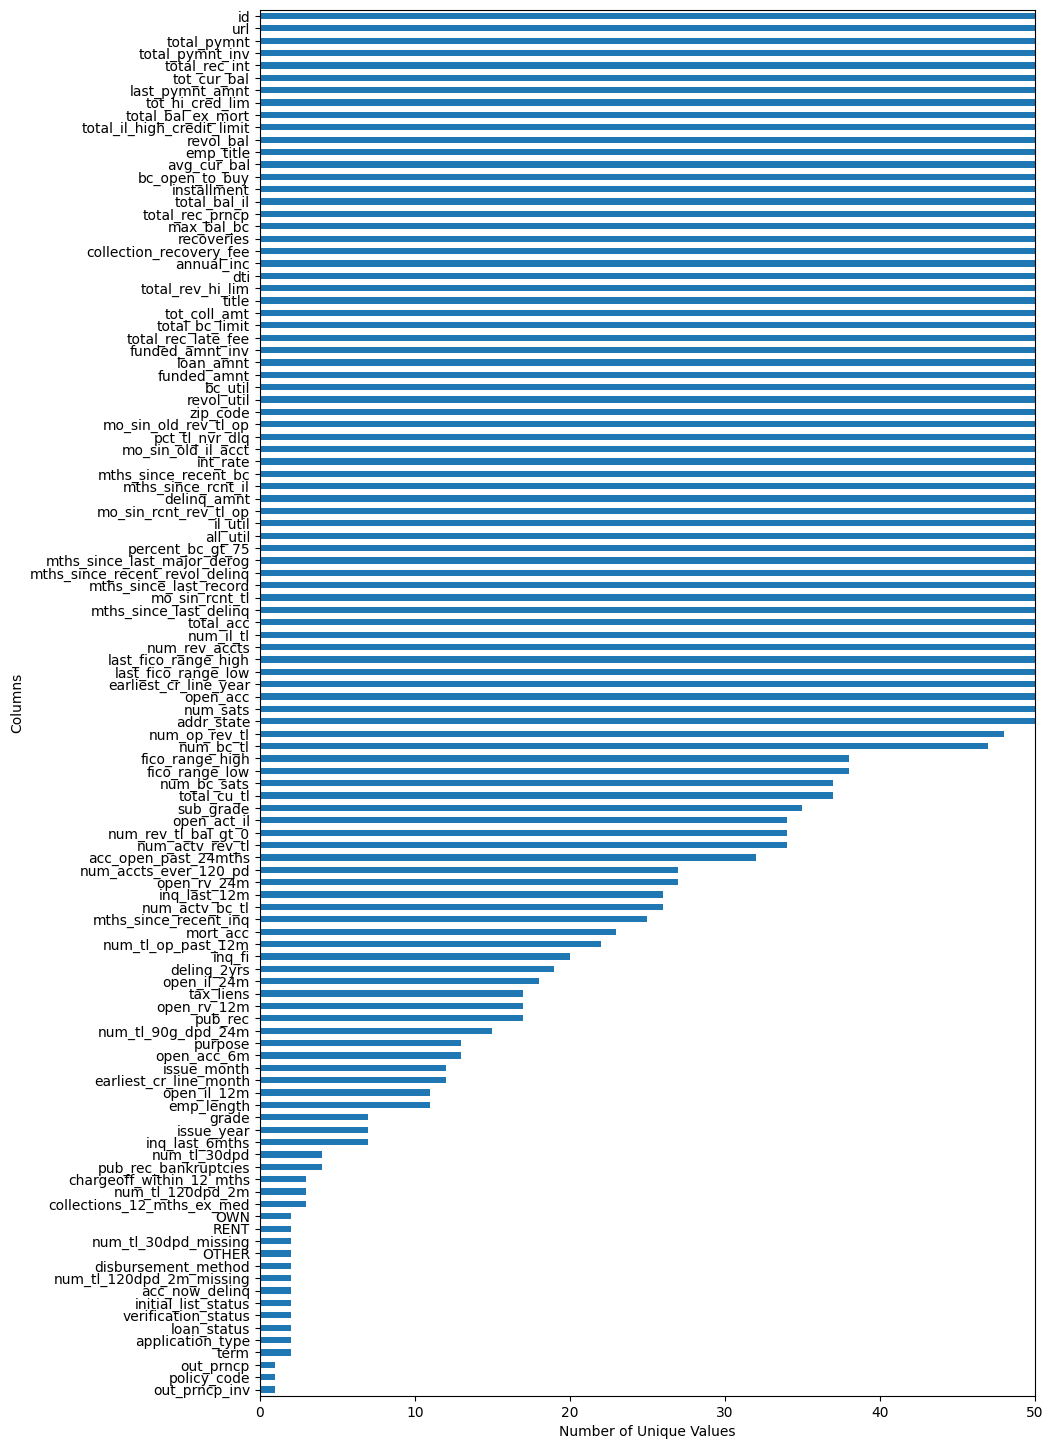

In [37]:
df.nunique().sort_values().plot(kind='barh', figsize=(10, 18))
plt.xlim(0, 50)  # limit to 0–40 unique values
plt.xlabel("Number of Unique Values")
plt.ylabel("Columns")
plt.show()

This horizontal bar chart is a useful visual way to see how many categorical and non-categorical columns there are, and which ones are of each type. 

In [38]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
object_cols  = df.select_dtypes(include=['object']).columns.tolist()

numeric_categorical_cols = [c for c in numeric_cols if df[c].nunique() < 20]
numeric_continuous_cols = [c for c in numeric_cols if df[c].nunique() >= 20]

categorical_cols = [c for c in object_cols if df[c].nunique() < 20]
text_heavy_cols = [c for c in object_cols if df[c].nunique() >= 20]

print(f"Numeric continuous columns: {len(numeric_continuous_cols)}")
print(f"Numeric categorical columns: {len(numeric_categorical_cols)}")
print(f"Categorical-like columns: {len(categorical_cols)}")
print(f"Text-heavy columns: {len(text_heavy_cols)}")

Numeric continuous columns: 70
Numeric categorical columns: 30
Categorical-like columns: 2
Text-heavy columns: 7


In [39]:
for c in numeric_continuous_cols:
    try:
        print(df[c].value_counts(dropna=False))
    except(KeyError):
        continue

    

loan_amnt
10000.0    4274
12000.0    3111
20000.0    3007
15000.0    2959
35000.0    2343
           ... 
31100.0       1
22225.0       1
26525.0       1
1475.0        1
1225.0        1
Name: count, Length: 1307, dtype: int64
funded_amnt
10000.0    4274
12000.0    3111
20000.0    3007
15000.0    2959
35000.0    2343
           ... 
34100.0       1
32125.0       1
23575.0       1
36875.0       1
31550.0       1
Name: count, Length: 1307, dtype: int64
funded_amnt_inv
10000.0    4054
12000.0    2903
20000.0    2729
15000.0    2725
35000.0    2004
           ... 
28575.0       1
1825.0        1
38250.0       1
39700.0       1
36875.0       1
Name: count, Length: 1356, dtype: int64
int_rate
10.99    1698
11.99    1411
13.99    1287
5.32     1223
9.17     1175
         ... 
22.78       2
15.29       1
24.20       1
23.26       1
10.33       1
Name: count, Length: 357, dtype: int64
installment
327.34    150
301.15    111
332.10    110
261.88     95
491.01     93
         ... 
200.03      1
32

In [40]:
df = df.drop(columns=['id', 'emp_title', 'url', 'title', 'zip_code', 'addr_state'])

text-heavy columns will be dropped since we are not going to use NLP in this project, and are therefore of no use to our model

<br>

In [41]:
sub_grade_list = ['A1','A2','A3','A4','A5',
  'B1','B2','B3','B4','B5',
  'C1','C2','C3','C4','C5',
  'D1','D2','D3','D4','D5',
  'E1','E2','E3','E4','E5',
  'F1','F2','F3','F4','F5',
  'G1','G2','G3','G4','G5',
]

sub_grade_map = {sg: i for i, sg in enumerate(sub_grade_list, start=1)}
df['sub_grade'] = df['sub_grade'].map(sub_grade_map).astype('int8')

df = df.drop(columns='grade')

Since 'sub_grade' contains finer granilarity within the 'grade' column, and is also ordinal (A1 is less riskier than A3 even though they both are in A), I will encode into integers such that the ordinal nature is captivated by the model. Also dropping 'grade' col since its fully implied by 'sub_grade' and therefore redundant (will confuse tree model and create unnecessary splits).

<br>

In [42]:
df['emp_length'] = df['emp_length'].str.extract(r'(\d+)')
df['emp_length'] = df['emp_length'].fillna(1).astype('int8')

In [43]:
df = df[~df['purpose'].isin(['educational', 'renewable_energy'])].reset_index(drop=True)
dummies = pd.get_dummies(df['purpose'], drop_first=True)
df = pd.concat([df, dummies], axis=1)

Dropping loans that are for 'educational' or 'renewable_energy' since these are extremely rare and only introduce noise and variance to the model, hence are not good to keep.

<br>

In [44]:
df['delinq_2yrs'] = df['delinq_2yrs'].clip(upper=df['delinq_2yrs'].quantile(0.995))


In [45]:
df = df.drop(columns=['out_prncp', 'out_prncp_inv'])

These would only have values for a loan that is in 'loan_state' current, which I dropped from the df since we only care whether it defaulted or not, so ongoing loans are not useful. Hence the two cols on top are also not useful.

<br>

In [46]:
df.drop(columns='policy_code', inplace=True)

This column provides no variance (all rows are = 1)

In [47]:
df['num_tl_90g_dpd_24m'] = df['num_tl_90g_dpd_24m'].fillna(0).astype('int8')

cols_with_NaN = ['open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_rv_12m']

for c in cols_with_NaN:
    df[c] = df[c].fillna(-1)

cols_to_clip = ['delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'collections_12_mths_ex_med', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'tax_liens']

for c in cols_to_clip:
    df[c] = df[c].clip(upper=df[c].quantile(0.995))

df['chargeoff_within_12_mths'] = df['chargeoff_within_12_mths'].clip(upper=1)
df['num_tl_30dpd'] = (df['num_tl_30dpd'] > 0).astype('int8')
df['num_tl_120dpd_2m'] = (df['num_tl_120dpd_2m'] > 0).astype('int8')
df.loc[df['issue_year'] < 2010, 'issue_year'] = 2010


In [48]:
df.drop(columns=[
 'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
 'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt'
], inplace=True, errors='ignore')

These cols provide information post origination (after the loan had been admitted) and therefore leak future insights for the model (given the fact that we want to model).

<br>

In [49]:
#For these, NaNs usually mean None
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(0)
df['mths_since_last_record'] = df['mths_since_last_record'].fillna(0)
df['num_accts_ever_120_pd'] = df['num_accts_ever_120_pd'].fillna(0)
df['mths_since_last_major_derog'] = df['mths_since_last_major_derog'].fillna(0)
df['open_act_il'] = df['open_act_il'].fillna(0)
df['mths_since_rcnt_il'] = df['mths_since_rcnt_il'].fillna(0)
df['total_bal_il'] = df['total_bal_il'].fillna(0)
df['il_util'] = df['il_util'].fillna(0)
df['open_rv_24m'] = df['open_rv_24m'].fillna(0)
df['max_bal_bc'] = df['max_bal_bc'].fillna(0)
df['all_util'] = df['all_util'].fillna(0)
df['total_cu_tl'] = df['total_cu_tl'].fillna(0)
df['mths_since_recent_revol_delinq'] = df['mths_since_recent_revol_delinq'].fillna(0)


df['dti'] = df['dti'].fillna(df['dti'].median())
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

In [51]:
#unkown reason for NaNs, best to create a isna flag so that model can interpret missingness
isna_flags = pd.DataFrame({
    c + '_isna': df[c].isna().astype('int8') 
    for c in ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'inq_fi', 'inq_last_12m', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc',  'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']
    })

df = pd.concat([df, isna_flags], axis=1)

df[isna_flags.columns.str.replace('_isna', '')] = df[
    isna_flags.columns.str.replace('_isna', '')
].fillna(-1)

#Domain-specifc clips
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].clip(upper=120)
df['revol_util'] = df['revol_util'].clip(upper=100)
df['il_util'] = df['il_util'].clip(upper=100)
df['all_util'] = df['all_util'].clip(upper=100)
df['bc_util'] = df['bc_util'].clip(upper=100)

#statistical outliers
for c in ['open_acc', 'total_acc', 'tot_coll_amt', 'tot_cur_bal', 'open_act_il', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_24m', 'max_bal_bc', 'total_rev_hi_lim', 'total_cu_tl', 'acc_open_past_24mths', 'inq_fi', 'inq_last_12m', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'delinq_amnt', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m']:
    df[c] = df[c].clip(upper=df[c].quantile(0.995))
    